#**Issue Report Classification**

- This notebook contains the code for performing cleaning and pre-processing of the dataset provided for the NLBSE 2024 Issue Report Classification competition.

## Dataset Description
- **Dataset used:** Issue Report Classification competition 2024 dataset
<br/>Link to dataset: https://github.com/nlbse2024/issue-report-classification
- **Classes in dataset**:
    - bug
    - feature
    - question

- The dataset was collected from the following GitHub repositories:
    - bitcoin/bitcoin
    - facebook/react
    - microsoft/vscode
    - opencv/opencv
    - tensorflow/tensorflow

### Installing the required libraries

In [2]:
!pip install ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 676.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.8 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn

### Importing the necessary libraries

In [9]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.preprocessor import TextPreProcessor

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the datasets

I have downloaded the datasets provided by NLBSE'24 Tool Competition on Issue Report Classification and added them to the project repository. The following cell with read the train and test data files from the GitHub repository.

In [5]:
train_file_path = r"https://github.com/lhamu/issue-report-classification/raw/main/data/issues_train.csv"
test_file_path = r"https://github.com/lhamu/issue-report-classification/raw/main/data/issues_test.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [6]:
train_df.columns

Index(['repo', 'created_at', 'label', 'title', 'body'], dtype='object')

#### Checking the label distribution in the training dataset

bug         500
feature     500
question    500
Name: label, dtype: int64


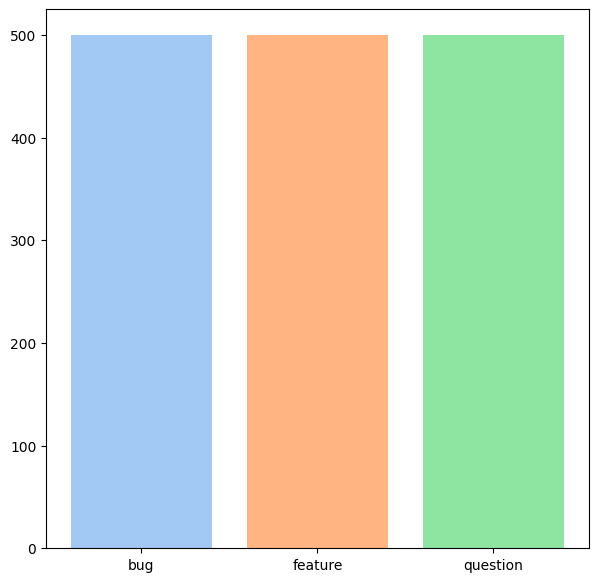

In [14]:
colors = sns.color_palette('pastel')[0:3]
plt.figure(figsize=(7,7))
value_counts = train_df['label'].value_counts()
print(value_counts)
labels = train_df['label'].unique()
value_counts = [value_counts[label] for label in labels]

plt.bar(labels, value_counts, color=colors)
plt.show()

#### Checking the label distribution for the test dataset

bug         500
feature     500
question    500
Name: label, dtype: int64


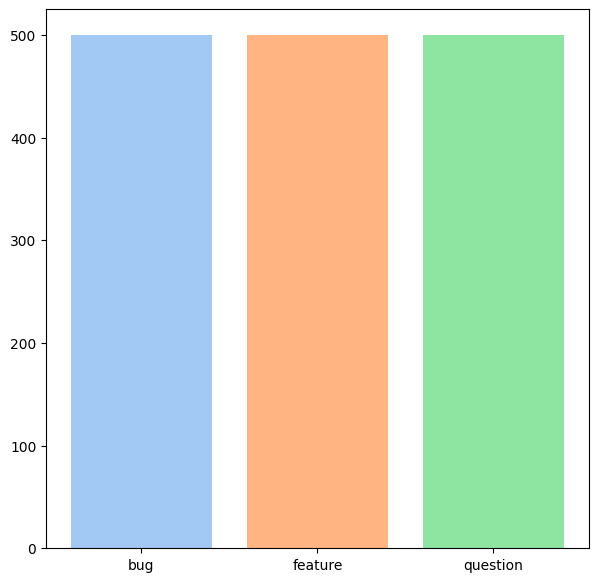

In [15]:
colors = sns.color_palette('pastel')[0:3]
plt.figure(figsize=(7,7))
value_counts = test_df['label'].value_counts()
print(value_counts)
labels = test_df['label'].unique()
value_counts = [value_counts[label] for label in labels]

plt.bar(labels, value_counts, color=colors)
plt.show()

Text(0.5, 1.0, 'Label distribution across repos in training dataset')

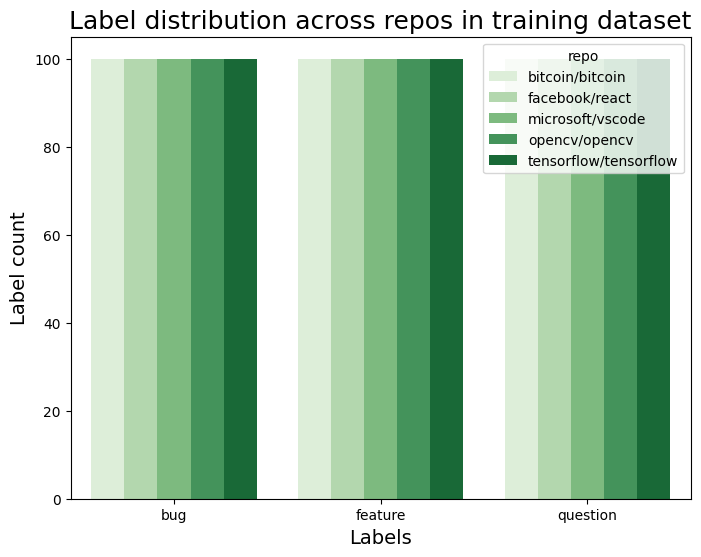

In [17]:
# transforming the dataset for barplot
train_data_df = train_df.groupby(['repo', 'label']).agg(count=('label', 'count'))

train_data_df = train_data_df.reset_index()

# code to plot a simple grouped barplot
plt.figure(figsize=(8, 6))
sns.barplot(x="label", y="count",
            hue="repo", data=train_data_df,
            palette='Greens')

plt.ylabel("Label count", size=14)
plt.xlabel("Labels", size=14)
plt.title("Label distribution across repos in training dataset", size=18)

Text(0.5, 1.0, 'Label distribution across repos in test dataset')

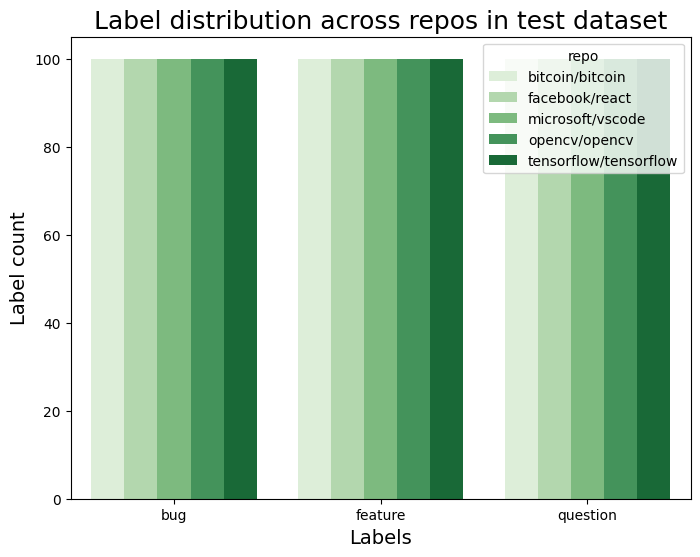

In [18]:
# transforming the dataset for barplot
test_data_df = test_df.groupby(['repo', 'label']).agg(count=('label', 'count'))

test_data_df = test_data_df.reset_index()

# code to plot a simple grouped barplot
plt.figure(figsize=(8, 6))
sns.barplot(x="label", y="count",
            hue="repo", data=test_data_df,
            palette='Greens')

plt.ylabel("Label count", size=14)
plt.xlabel("Labels", size=14)
plt.title("Label distribution across repos in test dataset", size=18)

### Preprocessing steps

* These cells contain the steps performed for cleaning the issue text.<br/>
* The dataset contains two columns: **title** and **body** which together make up the complete GitHub issue report.
    - For simplicity purposes, I combined the two columns using simple string concatenation to have a new column: **issue_text**.
* The following preprocessing steps are performed:
    - Removing multiple spaces from the text.
    - Changing all characters to lowercase.
    - Encoding the label text to have numerical representations instead.
    - Identifying and cleaning the text by removing image, links and code using regex.
    - Using Ekphrasis text processing pipeline to perform word tokenization and segmentation, spell correction and tokenization.

In [ ]:
# Ekphrasis provides a text preprocessing pipeline with different functionalities including social tokenizer, word segmentation, spell correction, and customization.
# Link to the ekphrasis github repo: https://github.com/cbaziotis/ekphrasis

# function to get the ekphrasis preprocessor
# This function applies normalization, word tokenization and segmentation,
# spell correction using the twitter corpus and tokenization
def get_ekphrasis_preprocessor():
    return TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
    )

In [ ]:
# data cleaning steps

import re

# dictionary to map labels to numerical representations
label_to_int = {
    "bug": 0,
    "feature": 1,
    "question": 2
}

# different regex strings to identify images, links, and code in the issue text
image_regex = re.compile('!(.*).*')
link_regex_1 = re.compile('(.*).*')
link_regex_2 = re.compile('(.*): [^\s]+')
code_regex = re.compile('(:?`[^`]+`|```[^`]*```)')

# function to perform data cleaning using regex and Ekphrasis preprocessor
def perform_data_cleaning(text, preprocessor):
    text = " ".join(text.split())
    text = text.lower()
    cleaned_text = re.sub(image_regex, r'\1 ', text)
    cleaned_text = re.sub(link_regex_1, r'\1 ', cleaned_text)
    cleaned_text = re.sub(link_regex_2, r'\1 ', cleaned_text)
    cleaned_text = re.sub(code_regex, r'\1 ', cleaned_text)

    cleaned_text = " ".join(preprocessor.pre_process_doc(cleaned_text))

    return cleaned_text

# function to apply data cleaning steps on the dataframe
def preprocess_dataframe(df):
    preprocessor = get_ekphrasis_preprocessor()
    cleaned_df = df.copy()
    cleaned_df["issue_text"] = cleaned_df.apply(lambda x: str(x["title"]) + " " + str(x["body"]), axis=1)
    label_encoder = lambda x: label_to_int[x]
    cleaned_df["label"] = [label_encoder(x) for x in cleaned_df['label']]
    cleaned_df = cleaned_df[["repo", "issue_text", "label"]]
    cleaned_df["issue_text"] = cleaned_df["issue_text"].apply(lambda x: perform_data_cleaning(x, preprocessor))

    return cleaned_df

cleaned_train_df = preprocess_dataframe(train_df)
cleaned_test_df = preprocess_dataframe(test_df)


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


#### Saving the preprocessed data

In [ ]:
cleaned_train_df.to_csv("preprocessed_issues_train.csv", index=False)
cleaned_test_df.to_csv("preprocessed_issues_test.csv", index=False)
